# Bayesian Poisson Regression
This notebook is ported from the [example notebook](https://docs.pymc.io/notebooks/GLM-poisson-regression.html) of PyMC3 on Poisson Regression.  

[Poisson Regression](https://en.wikipedia.org/wiki/Poisson_regression) is a technique commonly used to model count data. Some of the applications include predicting the number of people defaulting on their loans or the number of cars running on a highway on a given day.This example describes a method to implement the Bayesian version of this technique using Turing.

We will generate the dataset that we will be working on which describes the relationship between number of times a person sneezes during the day with his alcohol consumption and medicinal intake.

We start by importing the required libraries.

In [1]:
#Import Turing, Distributions and DataFrames
using Turing, Distributions, DataFrames

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
MCMCChain, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

loaded


# Generating data
We start off by creating a toy dataset. We take the case of a person who takes medicines to prevent excessive sneezing. Alcohol consumption increases the rate of sneezing for that person. Thus, the two factors affecting the number of sneezes in a given day are alcohol consumption and whether the person has taken his medicine. Both these variable are taken as boolean valued while the number of sneezes will be a count valued variable. We also take into consideration that the interaction between the two boolean variables will affect the number of sneezes

The first and the last 10 lines are printed to get a gist of the data generated.

In [13]:
theta_noalcohol_meds = 1    # no alcohol, took a medicine
theta_alcohol_meds = 3      # alcohol, took a medicine
theta_noalcohol_nomeds = 6  # no alcohol, no medicine
theta_alcohol_nomeds = 36   # alcohol, no medicine

# no of samples for each of the above cases
q = 1000

#Generate data from different Poisson distributions
noalcohol_meds = Poisson(theta_noalcohol_meds)
alcohol_meds = Poisson(theta_alcohol_meds)
noalcohol_nomeds = Poisson(theta_noalcohol_nomeds)
alcohol_nomeds = Poisson(theta_alcohol_nomeds)

nsneeze_data = vcat(rand(noalcohol_meds, q), rand(alcohol_meds, q), rand(noalcohol_nomeds, q), rand(alcohol_nomeds, q) )
alcohol_data = vcat(zeros(q), ones(q), zeros(q), ones(q) )
meds_data = vcat(zeros(q), zeros(q), ones(q), ones(q) )

df = DataFrame(nsneeze = nsneeze_data, alcohol_taken = alcohol_data, nomeds_taken = meds_data, product_alcohol_meds = meds_data.*alcohol_data)
first(df, 10), last(df, 10)

(10×4 DataFrame
│ Row │ nsneeze │ alcohol_taken │ nomeds_taken │ product_alcohol_meds │
│     │ Int64   │ Float64       │ Float64      │ Float64              │
├─────┼─────────┼───────────────┼──────────────┼──────────────────────┤
│ 1   │ 0       │ 0.0           │ 0.0          │ 0.0                  │
│ 2   │ 0       │ 0.0           │ 0.0          │ 0.0                  │
│ 3   │ 1       │ 0.0           │ 0.0          │ 0.0                  │
│ 4   │ 3       │ 0.0           │ 0.0          │ 0.0                  │
│ 5   │ 0       │ 0.0           │ 0.0          │ 0.0                  │
│ 6   │ 1       │ 0.0           │ 0.0          │ 0.0                  │
│ 7   │ 1       │ 0.0           │ 0.0          │ 0.0                  │
│ 8   │ 0       │ 0.0           │ 0.0          │ 0.0                  │
│ 9   │ 1       │ 0.0           │ 0.0          │ 0.0                  │
│ 10  │ 0       │ 0.0           │ 0.0          │ 0.0                  │, 10×4 DataFrame
│ Row │ nsneeze │ alcohol_taken 

# Visualisation of the dataset
We plot the distribution of the number of sneezes for the 4 different cases taken above. As expected, the person sneezes the most when he has taken alcohol and not taken his medicines. He sneezes the least when he doesn't consume alcohol and takes his medicines

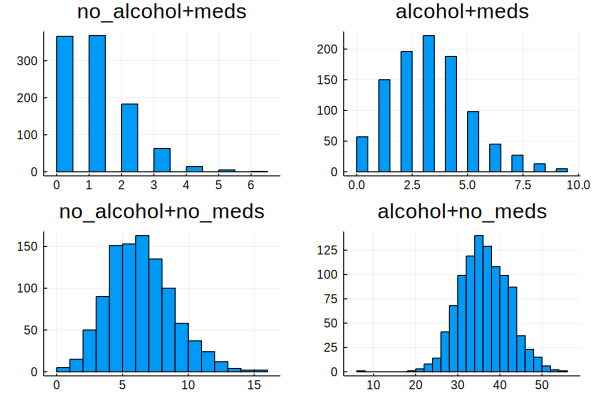

In [21]:
#Data Plotting

p1 = Plots.histogram(df[1:1000, 1], title = "no_alcohol+meds")  
p2 = Plots.histogram((df[1000:2000, 1]), title = "alcohol+meds")  
p3 = Plots.histogram((df[2000:3000, 1]), title = "no_alcohol+no_meds")  
p4 = Plots.histogram((df[3000:4000, 1]), title = "alcohol+no_meds")  
plot(p1, p2, p3, p4, layout = (2, 2), legend = false)

We must convert our `DataFrame` data into the `Matrix` form as the manipulations that we are about are designed to work with `Matrix` data. We also separate the features from the labels which will be later used by the Turing sampler to generate samples from the posterior.

In [29]:
# Convert the DataFrame object to matrices.
data = Matrix(df[[:alcohol_taken, :nomeds_taken, :product_alcohol_meds]])
data_labels = df[:nsneeze]
data

4000×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮            
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

We must recenter our data about 0 to help the Turing sampler in initialising the parameter estimates. So, normalising the data in each column by subtracting the mean and dividing by the standard deviation:

In [33]:
# # Rescale our matrices.
data = (data .- mean(data, dims=1)) ./ std(data, dims=1)

4000×3 Array{Float64,2}:
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
  ⋮                             
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 

# Declaring the Model: Poisson Regression
Our model, `poisson_regression` takes four arguments:

- `x` is our set of independent variables;
- `y` is the element we want to predict;
- `n` is the number of observations we have; and
- `σ²` is the standard deviation we want to assume for our priors.

Within the model, we create four coefficients (`b0`, `b1`, `b2`, and `b3`) and assign a prior of normally distributed with means of zero and standard deviations of `σ²`. We want to find values of these four coefficients to predict any given `y`. 

Intuitively, we can think of the coefficients as:

- `b1` is the coefficient which represents the effect of taking alcohol on the number of sneezes; 
- `b2` is the coefficient which represents the effect of taking in no medicines on the number of sneezes; 
- `b3` is the coefficient which represents the effect of interaction between taking alcohol and no medicines on the number of sneezes; 

The `for` block creates a variable `theta` which is the weighted combination of the input features. We have defined the priors on these weights above. We then observe the likelihood of calculating `theta` given the actual label, `y[i]`.

In [7]:
# Bayesian poisson regression (LR)
@model poisson_regression(x, y, n, σ²) = begin
    b0 ~ Normal(0, σ²)
    b1 ~ Normal(0, σ²)
    b2 ~ Normal(0, σ²)
    b3  ~ Normal(0, σ²)
#     y = tzeros(Int, n)
    for i = 1:n
        theta = b0 + b1*x[i, 1] + b2*x[i,2] + b3*x[i,3]
        y[i] ~ Poisson(exp(theta))
    end
end;

# Sampling from the posterior
We use the `NUTS` sampler to sample values from the posterior.

In [34]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Retrieve the number of observations.
n, _ = size(data)

# Sample using NUTS.
chain = sample(poisson_regression(data, data_labels, n, 10), NUTS(1500, 200, 0.65) )
describe(chain)

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/sghu6/src/inference/support/hmc_core.jl:240
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/sghu6/src/core/ad.jl:168
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/sghu6/src/core/ad.jl:169
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/sghu6/src/core/ad.jl:168
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/sghu6/src/core/ad.jl:169
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/sghu6/src/core/ad.jl:168
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/sghu6/src/core/ad.jl:169
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia

4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling...  9%  ETA: 0:09:32
  ϵ:         0.002185823613744191
  α:         0.9896946836920817
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 10%  ETA: 0:09:20
  ϵ:         0.004685345613931387
  α:         2.577702335453404e-5
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 10%  ETA: 0:09:25
  ϵ:         0.0022158930639704887
  α:         0.9875922416851287
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 10%  ETA: 0:09:25
  ϵ:         0.0006922057811663178
  α:         0.9992612906273097
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 10%  ETA: 0:09:40
  ϵ:         0.0016278410838834613
  α:         0.9870525611573175
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 11%  ETA: 0:09:46
  ϵ:         0.0009812224087922638
  α:         0.9944175998119996
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 11%  ETA: 0:09:45
  ϵ:         0.0008288371999603836
  α:         0.9998103240283343
4m  pr

[NUTS] Sampling... 19%  ETA: 0:09:00
  ϵ:         0.002918115029071684
  α:         0.993350313821538
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 19%  ETA: 0:09:02
  ϵ:         0.002918115029071684
  α:         0.8859152810983495
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 19%  ETA: 0:09:04
  ϵ:         0.002918115029071684
  α:         0.9962909082505874
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 19%  ETA: 0:09:06
  ϵ:         0.002918115029071684
  α:         0.9872513632511967
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 19%  ETA: 0:09:08
  ϵ:         0.002918115029071684
  α:         0.9539132717741615
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 19%  ETA: 0:09:06
  ϵ:         0.002918115029071684
  α:         0.9734335777447404
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 20%  ETA: 0:09:01
  ϵ:         0.002918115029071684
  α:         0.7084924960193102
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Samplin

[NUTS] Sampling... 27%  ETA: 0:08:17
  ϵ:         0.002918115029071684
  α:         0.5914238848669682
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 27%  ETA: 0:08:17
  ϵ:         0.002918115029071684
  α:         0.9987212020715366
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 27%  ETA: 0:08:14
  ϵ:         0.002918115029071684
  α:         0.8640018009483283
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 28%  ETA: 0:08:10
  ϵ:         0.002918115029071684
  α:         0.845192895256391
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 28%  ETA: 0:08:04
  ϵ:         0.002918115029071684
  α:         0.9699697925777198
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 28%  ETA: 0:08:03
  ϵ:         0.002918115029071684
  α:         0.9095620423385933
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 29%  ETA: 0:08:01
  ϵ:         0.002918115029071684
  α:         0.990968520167268
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling

[NUTS] Sampling... 36%  ETA: 0:07:12
  ϵ:         0.002918115029071684
  α:         0.7375290819989629
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 37%  ETA: 0:07:08
  ϵ:         0.002918115029071684
  α:         0.8957182600461268
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 37%  ETA: 0:07:05
  ϵ:         0.002918115029071684
  α:         0.6919912251767409
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 37%  ETA: 0:07:05
  ϵ:         0.002918115029071684
  α:         0.9781157064265109
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 37%  ETA: 0:07:05
  ϵ:         0.002918115029071684
  α:         0.8540534677406297
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 37%  ETA: 0:07:05
  ϵ:         0.002918115029071684
  α:         0.9741722538761834
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 37%  ETA: 0:07:05
  ϵ:         0.002918115029071684
  α:         0.9168778917902869
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampli

[NUTS] Sampling... 45%  ETA: 0:06:19
  ϵ:         0.002918115029071684
  α:         0.9983958182239159
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 45%  ETA: 0:06:16
  ϵ:         0.002918115029071684
  α:         0.6619522508703106
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 45%  ETA: 0:06:15
  ϵ:         0.002918115029071684
  α:         0.9614541829502596
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 45%  ETA: 0:06:12
  ϵ:         0.002918115029071684
  α:         0.8052282006554763
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 46%  ETA: 0:06:09
  ϵ:         0.002918115029071684
  α:         0.9994340978686218
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 46%  ETA: 0:06:07
  ϵ:         0.002918115029071684
  α:         0.7817651818358018
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 46%  ETA: 0:06:05
  ϵ:         0.002918115029071684
  α:         0.965318135711652
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Samplin

[NUTS] Sampling... 53%  ETA: 0:05:22
  ϵ:         0.002918115029071684
  α:         0.9991594002022032
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 53%  ETA: 0:05:20
  ϵ:         0.002918115029071684
  α:         0.5428072220233835
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 54%  ETA: 0:05:19
  ϵ:         0.002918115029071684
  α:         0.9107628635771505
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 54%  ETA: 0:05:17
  ϵ:         0.002918115029071684
  α:         0.8552952139766621
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 54%  ETA: 0:05:15
  ϵ:         0.002918115029071684
  α:         0.5034998117021845
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 54%  ETA: 0:05:14
  ϵ:         0.002918115029071684
  α:         0.9503430706999156
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 54%  ETA: 0:05:13
  ϵ:         0.002918115029071684
  α:         1.0
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 55%  ETA:

[NUTS] Sampling... 62%  ETA: 0:04:22
  ϵ:         0.002918115029071684
  α:         0.9782652479806679
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 62%  ETA: 0:04:21
  ϵ:         0.002918115029071684
  α:         0.819312848829636
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 62%  ETA: 0:04:21
  ϵ:         0.002918115029071684
  α:         0.927823568599877
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 62%  ETA: 0:04:19
  ϵ:         0.002918115029071684
  α:         0.9554911063659577
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 63%  ETA: 0:04:18
  ϵ:         0.002918115029071684
  α:         0.5481993162466028
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 63%  ETA: 0:04:18
  ϵ:         0.002918115029071684
  α:         0.99672451275832
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 63%  ETA: 0:04:17
  ϵ:         0.002918115029071684
  α:         0.8307757351789423
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling..

[NUTS] Sampling... 70%  ETA: 0:03:31
  ϵ:         0.002918115029071684
  α:         0.9935305842812155
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 70%  ETA: 0:03:29
  ϵ:         0.002918115029071684
  α:         0.8789877164146909
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 70%  ETA: 0:03:29
  ϵ:         0.002918115029071684
  α:         0.8645417358960967
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 70%  ETA: 0:03:27
  ϵ:         0.002918115029071684
  α:         0.9262717976143894
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 70%  ETA: 0:03:27
  ϵ:         0.002918115029071684
  α:         0.9695078081880646
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 71%  ETA: 0:03:25
  ϵ:         0.002918115029071684
  α:         0.997144618628726
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 71%  ETA: 0:03:23
  ϵ:         0.002918115029071684
  α:         0.9997428662552861
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Samplin

[NUTS] Sampling... 78%  ETA: 0:02:31
  ϵ:         0.002918115029071684
  α:         0.759654293921633
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 79%  ETA: 0:02:29
  ϵ:         0.002918115029071684
  α:         0.7950469577797448
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 79%  ETA: 0:02:28
  ϵ:         0.002918115029071684
  α:         0.938506570583569
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 79%  ETA: 0:02:26
  ϵ:         0.002918115029071684
  α:         0.9766509271302306
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 79%  ETA: 0:02:25
  ϵ:         0.002918115029071684
  α:         0.8804565725825171
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 79%  ETA: 0:02:25
  ϵ:         0.002918115029071684
  α:         0.8336933748964822
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 79%  ETA: 0:02:23
  ϵ:         0.002918115029071684
  α:         0.9242544799327116
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling

[NUTS] Sampling... 87%  ETA: 0:01:32
  ϵ:         0.002918115029071684
  α:         0.9927860112434514
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 87%  ETA: 0:01:31
  ϵ:         0.002918115029071684
  α:         0.8151445023448003
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 87%  ETA: 0:01:30
  ϵ:         0.002918115029071684
  α:         0.8855403833945041
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 87%  ETA: 0:01:28
  ϵ:         0.002918115029071684
  α:         0.6499792239364682
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 88%  ETA: 0:01:26
  ϵ:         0.002918115029071684
  α:         0.9984246163077378
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 88%  ETA: 0:01:24
  ϵ:         0.002918115029071684
  α:         0.9571004865179076
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 88%  ETA: 0:01:23
  ϵ:         0.002918115029071684
  α:         0.9982374571659342
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampli

[NUTS] Sampling... 95%  ETA: 0:00:34
  ϵ:         0.002918115029071684
  α:         0.9747882434306054
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 95%  ETA: 0:00:33
  ϵ:         0.002918115029071684
  α:         0.7429765077363857
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 95%  ETA: 0:00:32
  ϵ:         0.002918115029071684
  α:         0.7988501282597282
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 96%  ETA: 0:00:31
  ϵ:         0.002918115029071684
  α:         0.9014153261148523
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 96%  ETA: 0:00:29
  ϵ:         0.002918115029071684
  α:         0.7664914249798558
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 96%  ETA: 0:00:28
  ϵ:         0.002918115029071684
  α:         0.9241797538741405
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampling... 96%  ETA: 0:00:27
  ϵ:         0.002918115029071684
  α:         0.9695165953152396
4m  pre_cond:  [1.0, 1.0, 1.0, 1.0]


[NUTS] Sampli

[NUTS] Finished with
  Running time        = 698.7528158779985;
  #lf / sample        = 0.0;
  #evals / sample     = 41.2;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0].
Iterations = 1:1500
Thinning interval = 1
Chains = 1
Samples per chain = 1500

Empirical Posterior Estimates:
               Mean             SD          Naive SE          MCSE         ESS   
  lf_num     0.0000000000    0.000000000  0.00000000000   0.00000000000       NaN
      b3     0.3098396645    0.060679800  0.00156674569   0.00853796177  50.51029
      b2     0.8759356355    0.048701899  0.00125747763   0.00644370989  57.12416
 elapsed     0.4658352106    0.332162538  0.00857639986   0.01183030764 788.33213
      lp -8989.3602329672 2610.708833854 67.40821223542 227.61267287702 131.56004
  lf_eps     0.0031105373    0.002417699  0.00006242472   0.00013198473 335.54990
eval_num    41.2000000000   29.481374362  0.76120581286   1.08853768227 733.51418
 epsilon     0.0031105373    0.002417699  0.00006242472   0.00013

[NUTS] Sampling...100% Time: 0:11:39


# Viewing the Diagnostics and Visualising the Posterior
So, we have obtained the posterior distributions of the parameters. We take the exponent of their meaned values and compare this with the intuitive meaning that was described earlier. The exponentiated mean of the coefficient `b1` is roughly half of that of `b2` which makes sense because in the data that we generated, the number of sneezes was more sensitive to the medicinal intake as compared to the alcohol consumption. We also get some dependence on the interaction between the alchol consumption and the medicinal intake as can be seen from the value of `b3`.

The exponent of the meaned values of the weights (or coefficients are): 
b0: 5.019208632916415 
b1: 1.6848919590709237 
b2: 2.345762184748618 
b3: 1.3946792177215832 
The posterior distributions obtained after sampling can be visualised as :


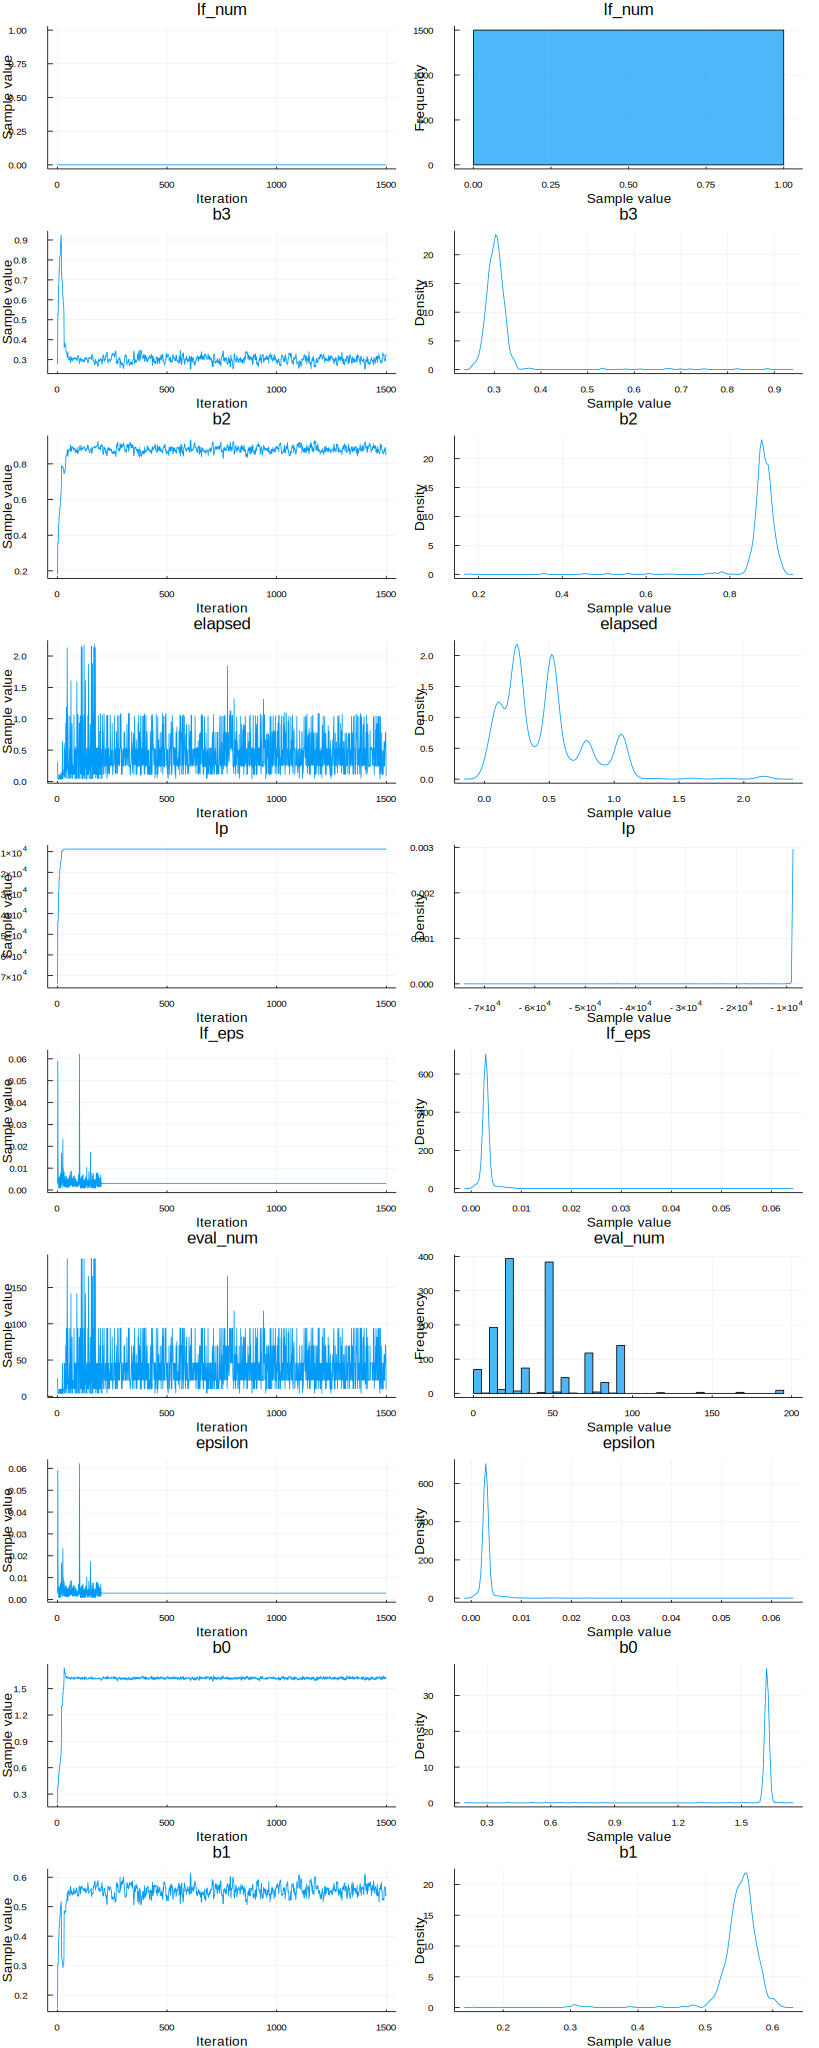

In [43]:
b0_exp = exp(mean(chain[:b0]))
b1_exp = exp(mean(chain[:b1]))
b2_exp = exp(mean(chain[:b2]))
b3_exp = exp(mean(chain[:b3]))
print("The exponent of the meaned values of the weights (or coefficients are): \n")
print("b0: ", b0, " \n", "b1: ", b1, " \n", "b2: ", b2, " \n", "b3: ", b3, " \n")
print("The posterior distributions obtained after sampling can be visualised as :\n")
plot(chain)